Import necessary libraries and files

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from nltk.stem import WordNetLemmatizer
import copy
import joblib
import matplotlib.pyplot as plt
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Load data
train_data = pd.read_csv('train.txt', delimiter=' ::: ', engine='python')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Qasem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Qasem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Qasem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaning data and 
Preprocessing

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Preprocess data

preprocess_data = copy.deepcopy(train_data)
preprocess_data['description'] = preprocess_data['description'].apply(preprocess_text)
data = preprocess_data



In [3]:
print('Unpreprocessed data\n',train_data['description'][1])
print('\npreprocessed and cleaned data\n',data['description'][1])

Unpreprocessed data
 Eighteen year-old Alex, 13 year-old Maggie, and four year old Kay are not happy about their mother's new union with a nameless, violent, blue-collar drunk, but agree to try and make it work. But when she is suddenly killed in a car crash, Alex is forced to mature quickly and look after his sisters as he promised. Looking to move them into a better life, he drops out of college and works full-time at a grocery store, making minimum wage. Meanwhile, with no barrier between them, the stepfather's bitter resentment grows more antagonistic. With Maggie on the verge of womanhood and Kay beginning to learn the ways of the world, Alex grows increasingly protective of his sisters' innocence with no support system other than his girlfriend, Courtney. But with the threat of prison and abandoning his sisters keeping Alex from violence, how far is he willing to go keep his family together?

preprocessed and cleaned data
 eighteen yearold alex 13 yearold maggie four year old kay

Plot train data for visualizing

<Axes: xlabel='genre'>

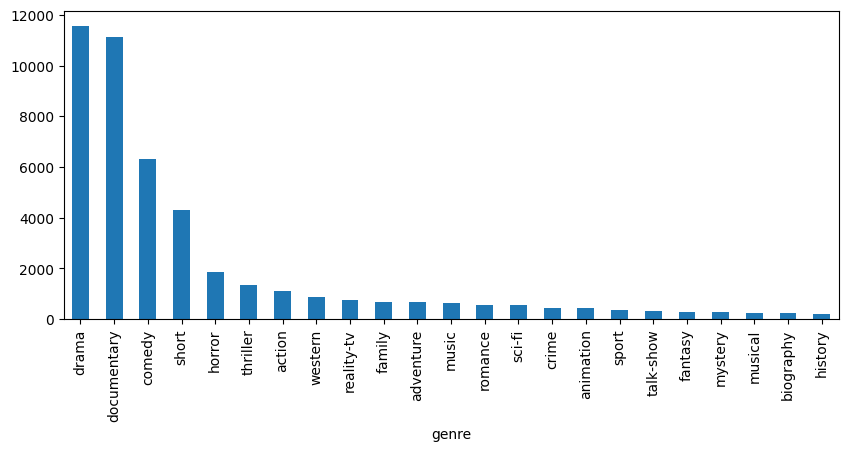

In [19]:
plt.figure(figsize=(10,4))
data['genre'].value_counts().plot(kind='bar')

Under sampling for balancing train data

In [4]:
# from imblearn.under_sampling import RandomUnderSampler

# X_train = copy.deepcopy(data['description'])
# y_train = copy.deepcopy(data['genre'])

# # تبدیل داده‌ها به فرمت مناسب
# X_train = X_train.values.reshape(-1, 1)

# # ایجاد نمونه‌های کاهشی
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# # تبدیل داده‌های کاهشی به DataFrame
# resampled_train_data = pd.DataFrame({
#     'description': X_resampled.flatten(),
#     'genre': y_resampled
# })

# des = []
# genre = []
# for i in range(len(X_resampled)):
#     des.append(X_resampled[i][0])
#     genre.append(y_resampled[i][0])

# n = pd.DataFrame({'description':des, 'genre':y_resampled})
# data = n

TF_IDF and test_train split  functions

In [5]:


# Precompute IDF values
def compute_idf(corpus):
    idf_dict = defaultdict(int)
    for document in corpus:
        unique_words = set(document.split())
        for word in unique_words:
            idf_dict[word] += 1
    total_documents = len(corpus)
    idf_dict = {word: np.log10(total_documents / count) for word, count in idf_dict.items()}
    return idf_dict
corpus = data['description'].tolist()
idf_dict = compute_idf(corpus)
# Compute TF-IDF
def compute_tf(text):
    tokens = text.split()
    tf_text = Counter(tokens)
    tf_text = {word: count / len(tokens) for word, count in tf_text.items()}
    return tf_text

# Train-test split function
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    X_train = X[train_indices]
    X_val = X[test_indices]
    y_train = y.iloc[train_indices]
    y_val = y.iloc[test_indices]
    return X_train, X_val, y_train, y_val




Implementing our model with default k = 10 ,  train of this model with big data will take too much time

In [6]:
class knn_model:
    def __init__(self,k=10):
        self.k = k
        
    def euclidean_distance(self,a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    def fit(self, corpus):
        # Compute TF-IDF
        
        idf_dict = compute_idf(corpus)
        tfidf_matrix = []
        for text in corpus:
            tfidf_text = {}
            computed_tf = compute_tf(text)
            for word in computed_tf:
                tfidf_text[word] = computed_tf[word] * idf_dict.get(word, 0)
            tfidf_matrix.append(tfidf_text)
        self.tfidf_matrix = tfidf_matrix
        # Convert the tfidf_matrix to a consistent format
        self.unique_words = set(word for doc in tfidf_matrix for word in doc.keys())
        
        self.word_index = {word: i for i, word in enumerate(self.unique_words)}
        tfidf_vectors = []
        for doc in tfidf_matrix:
            vector = np.zeros(len(self.unique_words))
            for word, tfidf in doc.items():
                vector[self.word_index[word]] = tfidf
            tfidf_vectors.append(vector)

        self.tfidf_vectors = np.array(tfidf_vectors)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.tfidf_vectors, data['genre'], test_size=0.3, random_state=42)
        return self.tfidf_vectors

    # KNN predict function
    def predict(self, x_test):
        distances = []
        for i in range(len(X_train)):
            dist = self.euclidean_distance(self.X_train[i], x_test)
            distances.append((dist, self.y_train.iloc[i]))
        
        distances.sort(key=lambda x: x[0])
        neighbors = distances[:self.k]
        output_values = [neighbor[1] for neighbor in neighbors]
        prediction = Counter(output_values).most_common(1)[0]
        return prediction


# training model
corpus = data['description'].tolist()
k = knn_model()
tfidf_vectors = k.fit(corpus)       
X_train, X_val, y_train, y_val = train_test_split(tfidf_vectors, data['genre'], test_size=0.3, random_state=42)

Storing model and tfidf_vectors By using joblib library to use later

In [7]:

joblib.dump(k, 'knn_model.pkl')
joblib.dump(tfidf_vectors, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

Classification Report 

In [13]:
y_pred = [k.predict(x)[0] for x in X_val]
test_data = pd.read_csv('test.txt', delimiter=' ::: ', engine='python')
def classification_report(y_true, y_pred):
    # unique_genres = {x: 0 for x in list(data['genre'].unique())}
    labels = list(set(y_true))
    y_pred_list = list(y_pred)

    # for x in y_pred_list:
    #     unique_genres[x] += 1

    report = {}
    total_true_positive = 0
    total_support = 0
    report[' '] = ' '
    for label in labels:
        true_positive = sum((y_true == label) & (y_pred == label))
        false_positive = sum((y_true != label) & (y_pred == label))
        false_negative = sum((y_true == label) & (y_pred != label))
        precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
        recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        support = sum(y_true == label)

        report[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        }

        total_true_positive += true_positive
        total_support += support

    accuracy = total_true_positive / total_support if total_support > 0 else 0

    # Calculate macro avg and weighted avg
    macro_avg = {
        'precision': np.mean([report[label]['precision'] for label in labels]),
        'recall': np.mean([report[label]['recall'] for label in labels]),
        'f1-score': np.mean([report[label]['f1-score'] for label in labels]),
        'support': total_support
    }

    weighted_avg = {
        'precision': np.sum([report[label]['precision'] * report[label]['support'] for label in labels]) / total_support,
        'recall': np.sum([report[label]['recall'] * report[label]['support'] for label in labels]) / total_support,
        'f1-score': np.sum([report[label]['f1-score'] * report[label]['support'] for label in labels]) / total_support,
        'support': total_support
    }
    report['  '] = ' '
    report['accuracy'] = {
        'precision':' ',
        'recall': ' ',
        'f1-score': accuracy,
        'support': total_support
    }

    report['macro avg'] = macro_avg
    report['weighted avg'] = weighted_avg

    report_df = pd.DataFrame(report).T

    return report_df

print(classification_report(np.array(y_val), np.array(y_pred)))

Restoring model and vectors

In [14]:
model = joblib.load('knn_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Preprocess and vectorize function
def vectorizer_transform(description):
    tfidf_matrix = model.tfidf_matrix
    word_index = model.word_index
    corpus = data['description'].tolist()        

    unique_words = model.unique_words
    idf_dict = compute_idf(corpus)
    description =  description[0]
    description = preprocess_text(description)
    computed_tf = compute_tf(description)
    tfidf_vector = np.zeros(len(unique_words))
    for word in description.split():
        if word in word_index:
            tfidf_vector[word_index[word]] = computed_tf[word] * idf_dict.get(word, 0)
    return tfidf_vector

# Predict genre function
def predict_genre(description):
    description_vector = vectorizer_transform([description])
    predicted_genre = model.predict( description_vector)
    return predicted_genre[0]




Custom test by using test_data

In [15]:
index = 110
new_description = test_data['description'][index]
predicted_genre = predict_genre(new_description)
print(f"Predicted Genre: {predicted_genre}")
print(test_data['genre'][index])

Predicted Genre: short
short


In [16]:
def predict_and_report(file):
    model = joblib.load('knn_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    new_data = pd.read_csv(file, delimiter= ' ::: ',engine='python')
    new_data['description'] = new_data['description'].apply(preprocess_text)
    X_new = vectorizer.transform(new_data['description'])
    y_true = new_data['genre']
    
    y_pred = model.predict(X_new)
    print(classification_report(y_true, y_pred))

predict_and_report('test.txt')

             precision    recall  f1-score support
                                                  
mystery        0.26087     0.375  0.307692    48.0
documentary   0.786503  0.652749  0.713411  1964.0
musical       0.358209  0.585366  0.444444    41.0
biography     0.161616       0.4  0.230216    40.0
western         0.6875  0.922581  0.787879   155.0
sport         0.471074  0.876923  0.612903    65.0
comedy        0.652131  0.589078  0.619003  1117.0
thriller       0.35809  0.564854  0.438312   239.0
music         0.367257  0.754545  0.494048   110.0
history       0.285714  0.611111  0.389381    36.0
short          0.47812  0.387648  0.428157   761.0
drama         0.730477   0.51763  0.605904  2042.0
action        0.456204  0.634518  0.530786   197.0
reality-tv    0.402542  0.714286  0.514905   133.0
family        0.357143  0.512821  0.421053   117.0
animation     0.421053      0.64  0.507937    75.0
romance        0.24055  0.693069  0.357143   101.0
sci-fi        0.439189  0.67010